In [1]:
CONSTRAINT_TOOLS = '/scratch/ucgd/lustre-work/quinlan/u6018199/constraint-tools'
CONSTRAINT_TOOLS_DATA = '/scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools'

import sys
sys.path.append(f'{CONSTRAINT_TOOLS}/utilities')

LOWER_DELETION_SIZE_LIMIT = 4000
UPPER_DELETION_SIZE_LIMIT = 10000
DELETION_ALLELE_FREQ_THRESHOLD = 0.00001

# Filter out false deletions: 
SUSPICIOUS_DELETION_SIZE_THRESHOLD = 1000000

DELETION_CLASS = 'observed' # TOPMED 

ENHANCERS_CLASS = 'constraint-labeled' # 'genehancer' requires more effort 

In [2]:
CHEN_DATA_DIRECTORY = f'{CONSTRAINT_TOOLS_DATA}/chen-et-al-2023-published-version/41586_2023_6045_MOESM4_ESM'
CHEN_FILE_STEM = 'Supplementary_Data_6_ESM'

## Get deletion coordinates relative to centers of enhancers 

In [3]:
from shell import shell
import pandas as pd

def intersect_enhancer_straddling_windows_with_deletions(deletion_type, window_size): 
  windows_with_deletions = f'{CONSTRAINT_TOOLS_DATA}/enhancer-straddling-windows/{ENHANCERS_CLASS}/enhancer-straddling-windows-intersect-{deletion_type}-{DELETION_CLASS}-deletions.bed'

  intersect_script = f'{CONSTRAINT_TOOLS}/experiments/germline-model/chen-et-al-2022/intersect-enhancer-straddling-windows-with-deletions.sh'

  cmd = (
    f'bash '
    f'{intersect_script} '
    f'{DELETION_CLASS} {windows_with_deletions} '
    f'{deletion_type} '
    f'{LOWER_DELETION_SIZE_LIMIT} {UPPER_DELETION_SIZE_LIMIT} {DELETION_ALLELE_FREQ_THRESHOLD} '
    f'{SUSPICIOUS_DELETION_SIZE_THRESHOLD} '
    f'{window_size} '
    f'{ENHANCERS_CLASS}'
  )
  print(shell(cmd))

  df = pd.read_csv(
    windows_with_deletions, 
    sep='\t',
  )

  return df 

intersect_enhancer_straddling_windows_with_deletions(
  deletion_type='short', 
  window_size=10000,
) 

Wrote windows with deletion overlaps to: /scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/enhancer-straddling-windows/constraint-labeled/enhancer-straddling-windows-intersect-short-observed-deletions.bed



,window_chrom,window_start,window_end,enhancer_chrom,enhancer_start,enhancer_end,gene,enhancer_Gnocchi,Haploinsufficient,MGI essential,...,SAS_Male_Het,SAS_Male_HomAlt,SAS_Male_HemiAlt,SAS_Male_HemiAF,SAS_Female_AF,SAS_Female_HomRef,SAS_Female_Het,SAS_Female_HomAlt,PopMax_AF,InPop
0,chr1,2540260,2550261,chr1,2545161,2545361,PANK4,2.775673,False,False,...,0,0,0,0.0,0.0,1377,0,0,0.000012,1
1,chr1,3666135,3676136,chr1,3670636,3671636,TP73,5.884122,False,True,...,0,0,0,0.0,0.0,1361,0,0,0.000006,1
2,chr1,6478439,6488440,chr1,6483340,6483540,ESPN,3.687737,False,False,...,0,0,0,0.0,0.0,1314,0,0,0.000413,1
3,chr1,8880240,8890241,chr1,8885141,8885341,ENO1,1.783420,False,True,...,2,0,0,0.0,0.0,1334,0,0,0.000224,1
4,chr1,8880240,8890241,chr1,8885141,8885341,ENO1,1.783420,False,True,...,0,0,0,0.0,0.0,1378,0,0,0.000006,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1504,chr9,122398920,122408921,chr9,122403521,122404321,OR1J4,3.026908,False,False,...,0,0,0,0.0,0.0,1369,0,0,0.000189,1
1505,chr9,122440320,122450321,chr9,122445121,122445521,OR1L8,2.466543,False,False,...,0,0,0,0.0,0.0,1370,0,0,0.001095,1
1506,chr9,122557420,122567421,chr9,122561921,122562921,OR1N2,2.900355,False,False,...,0,0,0,0.0,0.0,1374,0,0,0.002257,4
1507,chr9,122557720,122567721,chr9,122562521,122562921,OR1B1,2.900355,False,False,...,0,0,0,0.0,0.0,1374,0,0,0.002257,4


In [4]:
pd.set_option('display.max_rows', 50)

def update_deletion_coordinates_in_constraint_labeled_windows(deletion_type, window_size, constrained): 
  df = intersect_enhancer_straddling_windows_with_deletions(deletion_type, window_size)

  df = df[[
    'window_chrom', 
    'window_start', 
    'window_end', 
    'deletion_count',
    'sum merged_deletion_overlap',
    'enhancer coordinates',
    'enhancer_length',
    'deletion count per bp',
    'fraction of bps that are deleted',
    'truly constrained',
    'START', 
    'END', 
    'Het', 
    'SVLEN'
  ]]

  df = df[df['truly constrained'] == constrained]

  df = df[
    (df['window_chrom'] != 'chrX') &
    (df['window_chrom'] != 'chrY')
  ]

  df = df.rename(columns={
    'START': 'deletion_start',
    'END': 'deletion_end',
    'Het': 'number_of_het_samples',
    'SVLEN': 'deletion_size',
  })

  df['singleton'] = df['number_of_het_samples'] == 1

  df['window_center'] = (df['window_start'] + df['window_end']) / 2
  df['deletion_center'] = (df['deletion_start'] + df['deletion_end']) / 2

  df['deletion_start'] = df['deletion_start'] - df['window_center']
  df['deletion_end'] = df['deletion_end'] - df['window_center']
  df['deletion_center'] = df['deletion_center'] - df['window_center']

  df['deletion_start'] = df['deletion_start'].clip(-0.5*window_size, 0.5*window_size)
  df['deletion_end'] = df['deletion_end'].clip(-0.5*window_size, 0.5*window_size)
  df['deletion_center'] = df['deletion_center'].clip(-0.5*window_size, 0.5*window_size)

  return df

update_deletion_coordinates_in_constraint_labeled_windows(
  deletion_type='short', 
  window_size=10000,
  constrained=False,
)

Wrote windows with deletion overlaps to: /scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/enhancer-straddling-windows/constraint-labeled/enhancer-straddling-windows-intersect-short-observed-deletions.bed



,window_chrom,window_start,window_end,deletion_count,sum merged_deletion_overlap,enhancer coordinates,enhancer_length,deletion count per bp,fraction of bps that are deleted,truly constrained,deletion_start,deletion_end,number_of_het_samples,deletion_size,singleton,window_center,deletion_center
1380,chr1,158559509,158569510,2,200,chr1:158564410-158564610,200,0.01000,1.0,False,-2154.5,409.5,1,2564,True,158564509.5,-872.5
1381,chr1,158560109,158570110,1,200,chr1:158565010-158565210,200,0.00500,1.0,False,-2754.5,-190.5,1,2564,True,158565109.5,-1472.5
1382,chr1,158803809,158813810,3,800,chr1:158808410-158809210,800,0.00375,1.0,False,2077.5,2107.5,234,30,False,158808809.5,2092.5
1383,chr1,158803809,158813810,3,800,chr1:158808410-158809210,800,0.00375,1.0,False,3104.5,3180.5,6,76,False,158808809.5,3142.5
1384,chr10,5654736,5664737,0,0,chr10:5659637-5659837,200,0.00000,0.0,False,1652.5,2843.5,15,1191,False,5659736.5,2248.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1504,chr9,122398920,122408921,2,800,chr9:122403521-122404321,800,0.00250,1.0,False,-2327.5,1396.5,30,3724,False,122403920.5,-465.5
1505,chr9,122440320,122450321,1,400,chr9:122445121-122445521,400,0.00250,1.0,False,-5000.0,-3605.5,15,2070,False,122445320.5,-4640.5
1506,chr9,122557420,122567421,5,1000,chr9:122561921-122562921,1000,0.00500,1.0,False,4001.5,5000.0,217,2122,False,122562420.5,5000.0
1507,chr9,122557720,122567721,5,400,chr9:122562521-122562921,400,0.01250,1.0,False,3701.5,5000.0,217,2122,False,122562720.5,4762.5


## Get gene coordinates relative to centers of enhancers 

In [5]:
import pandas as pd

def get_enhancers_genes(constrained): 
  assert ENHANCERS_CLASS == 'constraint-labeled'
  deletion_type = 'all'
  deletion_class = 'observed' # TOPMED 
  # experiments/germline-model/chen-et-al-2022/SNV_plus_SV_model.4.ipynb
  enhancers_genes_and_constraint_labels = f'{CHEN_DATA_DIRECTORY}/{CHEN_FILE_STEM}-intersect-{deletion_type}-{deletion_class}-deletions-with-labels.bed'
  df = pd.read_csv(enhancers_genes_and_constraint_labels, sep='\t')  
  df = df.rename(columns={
    'gene': 'gene_symbol',    
  })
  df = df[df['truly constrained'] == constrained]
  df = df[['enhancer_chrom', 'enhancer_start', 'enhancer_end', 'enhancer coordinates', 'gene_symbol', 'truly constrained']]
  return df

get_enhancers_genes(constrained=False)

,enhancer_chrom,enhancer_start,enhancer_end,enhancer coordinates,gene_symbol,truly constrained
3682,chr1,19275306,19275506,chr1:19275306-19275506,AKR7A3,False
3683,chr1,47173728,47173928,chr1:47173728-47173928,CYP4A22,False
3684,chr1,52367328,52367928,chr1:52367328-52367928,ORC1,False
3685,chr1,54157127,54157327,chr1:54157127-54157327,CDCP2,False
3686,chr1,74734716,74734916,chr1:74734716-74734916,CRYZ,False
...,...,...,...,...,...,...
4030,chr9,122807921,122808121,chr9:122807921-122808121,OR1L4,False
4031,chr9,122807921,122808721,chr9:122807921-122808721,OR1L3,False
4032,chr9,122807921,122808921,chr9:122807921-122808921,OR1K1,False
4033,chr9,122807921,122808921,chr9:122807921-122808921,OR1L6,False


In [6]:
def get_gene_coordinates():
  genes = f'{CONSTRAINT_TOOLS_DATA}/genes/grch38/genes.sorted.bed'
  df = pd.read_csv(genes, sep='\t', header=None, names=['gene_chrom', 'gene_start', 'gene_end', 'gene_symbol'])
  df['gene coordinates'] = df['gene_chrom'] + ':' + df['gene_start'].astype(str) + '-' + df['gene_end'].astype(str)
  df['gene length'] = df['gene_end'] - df['gene_start']
  return df 

get_gene_coordinates()

,gene_chrom,gene_start,gene_end,gene_symbol,gene coordinates,gene length
0,chr1,65419,71585,OR4F5,chr1:65419-71585,6166
1,chr1,450740,451678,OR4F29,chr1:450740-451678,938
2,chr1,685716,686654,OR4F16,chr1:685716-686654,938
3,chr1,923923,944575,SAMD11,chr1:923923-944575,20652
4,chr1,944203,959309,NOC2L,chr1:944203-959309,15106
...,...,...,...,...,...,...
19830,chrY,24607560,24639207,BPY2B,chrY:24607560-24639207,31647
19831,chrY,24763069,24813492,DAZ3,chrY:24763069-24813492,50423
19832,chrY,24833843,24907040,DAZ4,chrY:24833843-24907040,73197
19833,chrY,25030901,25062548,BPY2C,chrY:25030901-25062548,31647


In [7]:
def get_gene_coordinates_relative_to_enhancers(constrained, window_size):
  df = pd.merge(
    get_enhancers_genes(constrained),
    get_gene_coordinates(),
    on='gene_symbol',
    how='inner',
  )

  df['enhancer and gene on same chromosome'] = df['enhancer_chrom'] == df['gene_chrom']
  print(df['enhancer and gene on same chromosome'].value_counts())
  df = df[df['enhancer and gene on same chromosome']]

  df = df[
    (df['enhancer_chrom'] != 'chrX') &
    (df['enhancer_chrom'] != 'chrY')
  ]
  
  df['enhancer_center'] = (df['enhancer_start'] + df['enhancer_end']) / 2

  df['gene_start'] = df['gene_start'] - df['enhancer_center']
  df['gene_end'] = df['gene_end'] - df['enhancer_center']

  df = df[df['gene_start'] < 0.5*window_size] # remove genes that start after the window ends
  df = df[df['gene_end'] > -0.5*window_size] # remove genes that end before the window starts
  
  df['gene_start'] = df['gene_start'].clip(-0.5*window_size, 0.5*window_size)
  df['gene_end'] = df['gene_end'].clip(-0.5*window_size, 0.5*window_size)

  return df 

get_gene_coordinates_relative_to_enhancers(
  constrained=False,
  window_size=10000
)

True    352
Name: enhancer and gene on same chromosome, dtype: int64


,enhancer_chrom,enhancer_start,enhancer_end,enhancer coordinates,gene_symbol,truly constrained,gene_chrom,gene_start,gene_end,gene coordinates,gene length,enhancer and gene on same chromosome,enhancer_center
3,chr1,54157127,54157327,chr1:54157127-54157327,CDCP2,False,chr1,-5000.0,-3457.0,chr1:54132968-54153770,20802,True,54157227.0
4,chr1,74734716,74734916,chr1:74734716-74734916,CRYZ,False,chr1,-5000.0,-1408.0,chr1:74705482-74733408,27926,True,74734816.0
13,chr1,158402010,158402810,chr1:158402010-158402810,OR10T2,False,chr1,-3888.0,-2944.0,chr1:158398522-158399466,944,True,158402410.0
18,chr1,158782610,158783010,chr1:158782610-158783010,OR6N2,False,chr1,-5000.0,-1606.0,chr1:158774222-158781204,6982,True,158782810.0
26,chr1,203491872,203492272,chr1:203491872-203492272,OPTC,False,chr1,2081.0,5000.0,chr1:203494153-203508949,14796,True,203492072.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,chr8,17613291,17614291,chr8:17613291-17614291,PDGFRL,False,chr8,-5000.0,5000.0,chr8:17576433-17644071,67638,True,17613791.0
325,chr8,18173091,18173291,chr8:18173091-18173291,NAT1,False,chr8,-2714.0,5000.0,chr8:18170477-18223689,53212,True,18173191.0
326,chr8,97821372,97821972,chr8:97821372-97821972,LAPTM4B,False,chr8,-5000.0,5000.0,chr8:97775057-97853013,77956,True,97821672.0
330,chr9,33403602,33404602,chr9:33403602-33404602,AQP7,False,chr9,-5000.0,-1420.0,chr9:33383179-33402682,19503,True,33404102.0


## Compute pileup and coverage of deletions in the vicinity of enhancers


In [8]:
import matplotlib.pyplot as plt

# https://www.nxn.se/valent/visualizing-overlapping-intervals
def intervals2layers(intervals):
  sorted_intervals = sorted(intervals, key=lambda interval: interval[0])
  layers = [[sorted_intervals[0]]]
  for interval in sorted_intervals[1:]:
    # else clause on a loop: 
    # https://docs.python.org/3/tutorial/controlflow.html#break-and-continue-statements-and-else-clauses-on-loops
    for layer in layers:  
      if layer[-1][1] < interval[0]: # no overlap
        layer.append(interval)
        break
    else:
      layers.append([interval])
  return layers

def plot_deletion_pileup(df):
  intervals = df[['deletion_start', 'deletion_end', 'singleton']].to_records(index=False).tolist()
  layers = intervals2layers(intervals)

  for i, layer in enumerate(layers):
    starts, ends, singletons = zip(*layer)
    colors = ['red' if singleton else 'green' for singleton in singletons]
    plt.hlines([i] * len(starts), starts, ends, colors=colors, lw=0.2, alpha=0.5) # type: ignore


In [9]:
from colorize import print_string_as_info
import numpy as np

def plot_deletion_coverage(df, deletion_type, window_size, singleton): 
  df = df.copy()

  df = df[df['singleton'] == singleton]

  number_of_deletions = len(df)
  average_deletion_length = int(np.mean(df['deletion_size']))

  df['deletion_chrom'] = 'synthetic_chrom'
  df['deletion_start'] = (df['deletion_start'] + window_size/2).astype(int)
  df['deletion_end'] = (df['deletion_end'] + window_size/2).astype(int)
  df = df[['deletion_chrom', 'deletion_start', 'deletion_end']]

  directory = f'{CONSTRAINT_TOOLS_DATA}/enhancer-straddling-windows/{ENHANCERS_CLASS}'

  singleton_label = 'singleton' if singleton else 'non-singleton'

  deletions_filename = f'{directory}/{deletion_type}-{DELETION_CLASS}-{singleton_label}-deletions.bed'
  df.to_csv(
    deletions_filename,
    sep='\t', 
    index=False, 
    header=False
  )
  print_string_as_info(f'Wrote deletions: {deletions_filename}')

  compute_coverage = f'{CONSTRAINT_TOOLS}/experiments/germline-model/chen-et-al-2022/compute-coverage.sh'
  coverage_filename = f'{directory}/{deletion_type}-{DELETION_CLASS}-{singleton_label}-deletions-coverage.bed'

  sliding_window_size = int(window_size/100)

  cmd = (
    f'bash {compute_coverage} {window_size} {deletions_filename} {coverage_filename} {sliding_window_size}'
  )
  print(shell(cmd))

  df = pd.read_csv(
    coverage_filename, 
    sep='\t',
    names=['chrom', 'start', 'end', 'coverage']
  )

  midpoints = 0.5*(df['start'] + df['end']) - window_size/2
  coverage = df['coverage']

  plt.plot(midpoints, coverage, color='red' if singleton else 'green')
  plt.ylabel(f'#deletions/{sliding_window_size}bp')

  return number_of_deletions, average_deletion_length

## Compute pileup and coverage of genes in the vicinity of enhancers


In [10]:
def plot_gene_pileup(df):
  intervals = df[['gene_start', 'gene_end']].to_records(index=False).tolist()
  layers = intervals2layers(intervals)

  for i, layer in enumerate(layers):
    starts, ends = zip(*layer)
    colors = 'black'
    plt.hlines([i] * len(starts), starts, ends, colors=colors, lw=0.2, alpha=0.5) # type: ignore


In [11]:
def plot_gene_coverage(df, window_size): 
  df = df.copy()

  df['gene_chrom'] = 'synthetic_chrom'
  df['gene_start'] = (df['gene_start'] + window_size/2).astype(int)
  df['gene_end'] = (df['gene_end'] + window_size/2).astype(int)
  df = df[['gene_chrom', 'gene_start', 'gene_end']]

  directory = f'{CONSTRAINT_TOOLS_DATA}/enhancer-straddling-windows/{ENHANCERS_CLASS}'

  genes_filename = f'{directory}/genes-targeted-by-enhancers.bed'
  df.to_csv(
    genes_filename,
    sep='\t', 
    index=False, 
    header=False
  )
  print_string_as_info(f'Wrote genes: {genes_filename}')

  compute_coverage = f'{CONSTRAINT_TOOLS}/experiments/germline-model/chen-et-al-2022/compute-coverage.sh'
  coverage_filename = f'{directory}/genes-targeted-by-enhancers-coverage.bed'

  sliding_window_size = int(window_size/100)

  cmd = (
    f'bash {compute_coverage} {window_size} {genes_filename} {coverage_filename} {sliding_window_size}'
  )
  print(shell(cmd))

  df = pd.read_csv(
    coverage_filename, 
    sep='\t',
    names=['chrom', 'start', 'end', 'coverage']
  )

  midpoints = 0.5*(df['start'] + df['end']) - window_size/2
  coverage = df['coverage']

  plt.plot(midpoints, coverage, color='black')
  plt.ylabel(f'#genes/{sliding_window_size}bp')

## Plot pileup and coverage in the vicinity of enhancers

In [12]:
# Set the font size
plt.rcParams['font.size'] = 30
plt.rcParams['figure.figsize'] = (14, 12)

def plot_pileup_and_coverage(deletion_type, window_size, constrained, ymax, plot_coverage): 

  fig, axs = plt.subplots(2, sharex=True)  

  # Plot deletion pileup on first subplot
  plt.sca(axs[0])  # Set the current Axes instance to the first subplot
  deletions = update_deletion_coordinates_in_constraint_labeled_windows(deletion_type, window_size, constrained)
  plot_deletion_pileup(deletions)  
  if plot_coverage: 
    deletion_numbers_and_lengths = {}
    for singleton in [True, False]:
      deletion_numbers_and_lengths[singleton] = plot_deletion_coverage(deletions, deletion_type, window_size, singleton)

  # Plot gene pileup on second subplot
  plt.sca(axs[1])  # Set the current Axes instance to the second subplot
  genes = get_gene_coordinates_relative_to_enhancers(constrained, window_size)
  plot_gene_pileup(genes)
  if plot_coverage: 
    plot_gene_coverage(genes, window_size)

  axs[0].set_ylim(0, ymax) 
  axs[1].set_xlabel('Distance (bp) from enhancer center')

  title = (
    f'enhancers constrained: {constrained}\n\n'
    f'{deletion_type}-deletion pileup'
  )
  if plot_coverage: 
    title += f'\n#deletions: {deletion_numbers_and_lengths[True][0]} (singletons), {deletion_numbers_and_lengths[False][0]} (non-singletons)' # type: ignore
    title += f'\nmean deletion length: {deletion_numbers_and_lengths[True][1]} (singletons), {deletion_numbers_and_lengths[False][1]} (non-singletons)' # type: ignore
  axs[0].set_title(title) 

  axs[1].set_title('target-gene pileup') 

  plt.show()

Wrote windows with deletion overlaps to: /scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/enhancer-straddling-windows/constraint-labeled/enhancer-straddling-windows-intersect-short-observed-deletions.bed



Wrote deletions: /scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/enhancer-straddling-windows/constraint-labeled/short-observed-singleton-deletions.bed
Wrote deletions: /scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/enhancer-straddling-windows/constraint-labeled/short-observed-non-singleton-deletions.bed


Wrote coverage: /scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/enhancer-straddling-windows/constraint-labeled/short-observed-singleton-deletions-coverage.bed

Wrote coverage: /scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/enhancer-straddling-windows/constraint-labeled/short-observed-non-singleton-deletions-coverage.bed

True    3677
Name: enhancer and gene on same chromosome, dtype: int64


Wrote genes: /scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/enhancer-straddling-windows/constraint-labeled/genes-targeted-by-enhancers.bed


Wrote coverage: /scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/enhancer-straddling-windows/constraint-labeled/genes-targeted-by-enhancers-coverage.bed



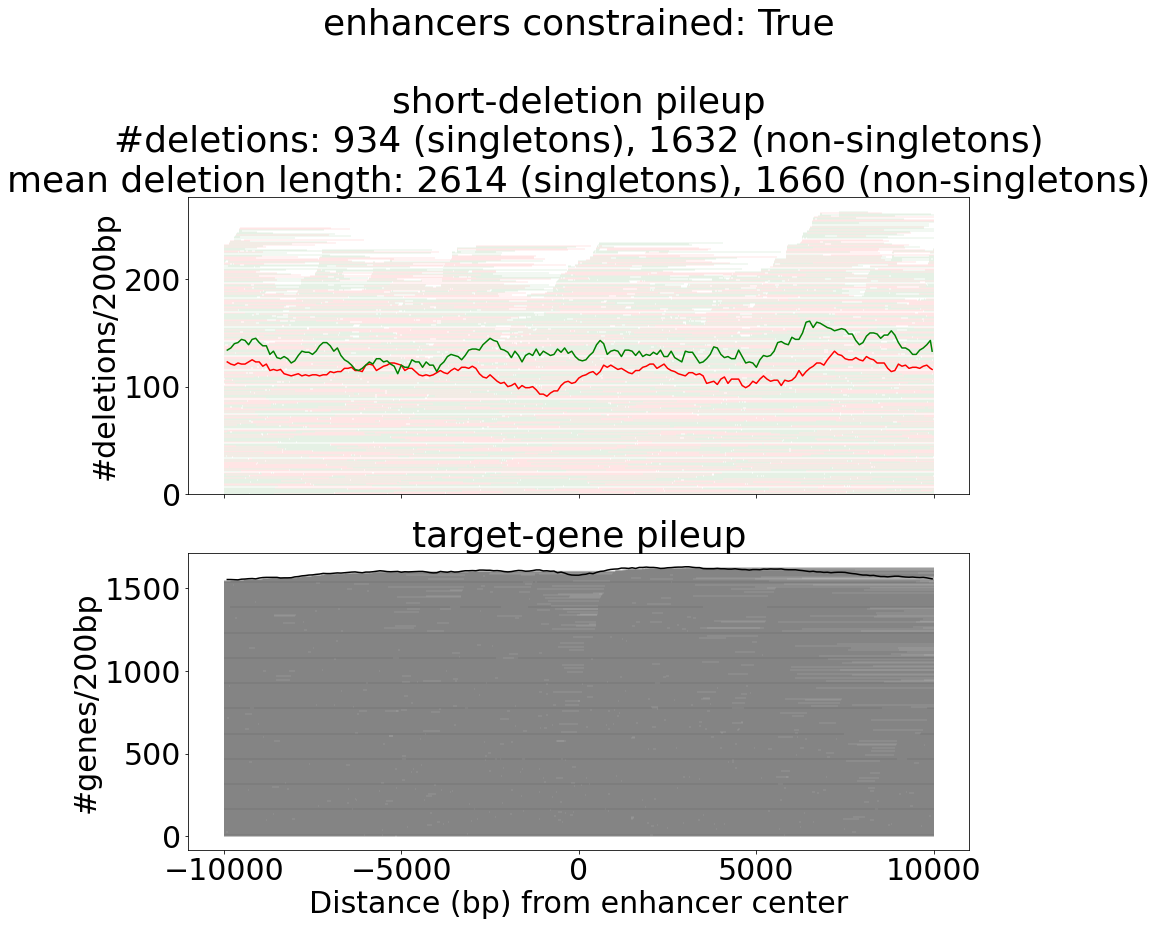

Wrote windows with deletion overlaps to: /scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/enhancer-straddling-windows/constraint-labeled/enhancer-straddling-windows-intersect-short-observed-deletions.bed



Wrote deletions: /scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/enhancer-straddling-windows/constraint-labeled/short-observed-singleton-deletions.bed
Wrote deletions: /scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/enhancer-straddling-windows/constraint-labeled/short-observed-non-singleton-deletions.bed


Wrote coverage: /scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/enhancer-straddling-windows/constraint-labeled/short-observed-singleton-deletions-coverage.bed

Wrote coverage: /scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/enhancer-straddling-windows/constraint-labeled/short-observed-non-singleton-deletions-coverage.bed

True    352
Name: enhancer and gene on same chromosome, dtype: int64
Wrote coverage: /scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/enhancer-straddling-windows/constraint-labeled/genes-targeted-by-enhancers-coverage.bed



Wrote genes: /scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/enhancer-straddling-windows/constraint-labeled/genes-targeted-by-enhancers.bed


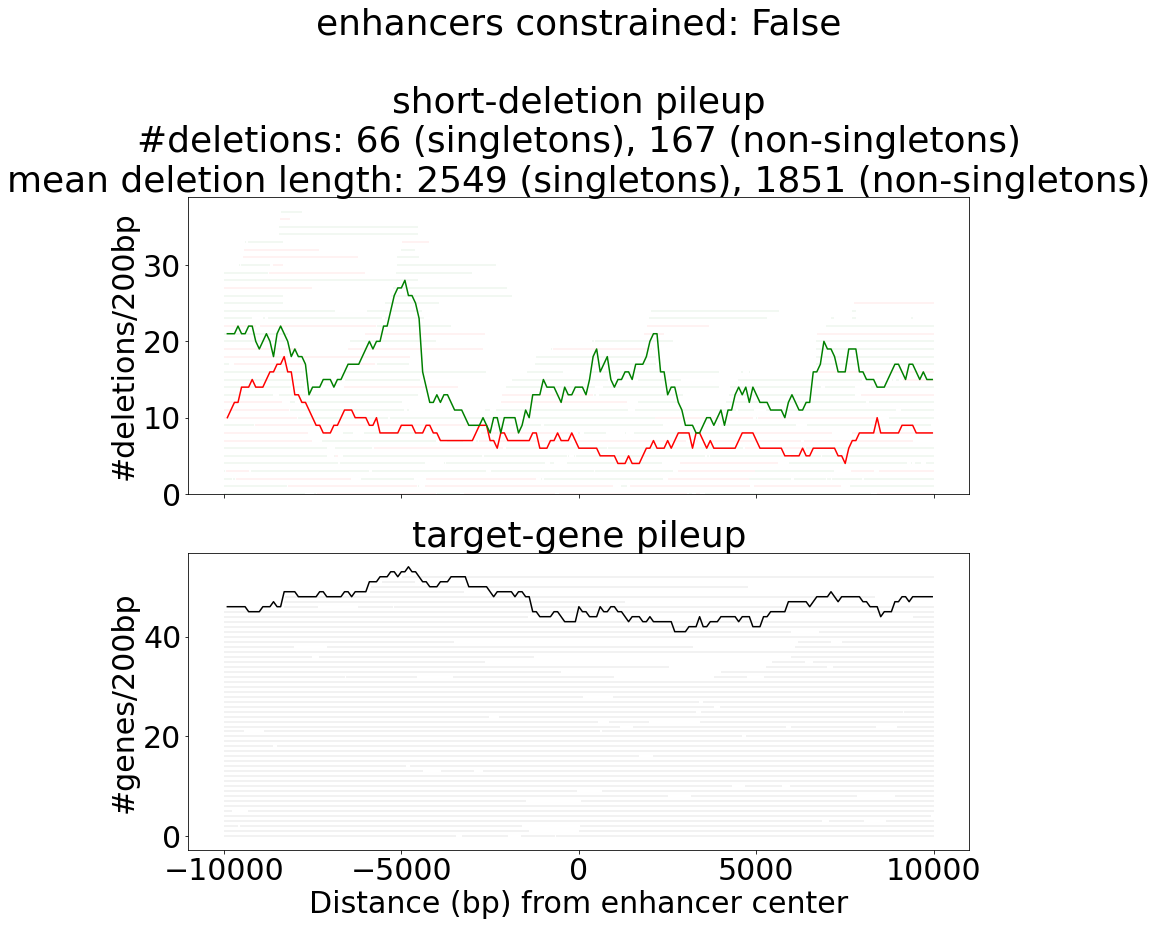

Wrote windows with deletion overlaps to: /scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/enhancer-straddling-windows/constraint-labeled/enhancer-straddling-windows-intersect-medium-observed-deletions.bed



Wrote deletions: /scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/enhancer-straddling-windows/constraint-labeled/medium-observed-singleton-deletions.bed
Wrote deletions: /scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/enhancer-straddling-windows/constraint-labeled/medium-observed-non-singleton-deletions.bed


Wrote coverage: /scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/enhancer-straddling-windows/constraint-labeled/medium-observed-singleton-deletions-coverage.bed

Wrote coverage: /scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/enhancer-straddling-windows/constraint-labeled/medium-observed-non-singleton-deletions-coverage.bed

True    3677
Name: enhancer and gene on same chromosome, dtype: int64


Wrote genes: /scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/enhancer-straddling-windows/constraint-labeled/genes-targeted-by-enhancers.bed


Wrote coverage: /scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/enhancer-straddling-windows/constraint-labeled/genes-targeted-by-enhancers-coverage.bed



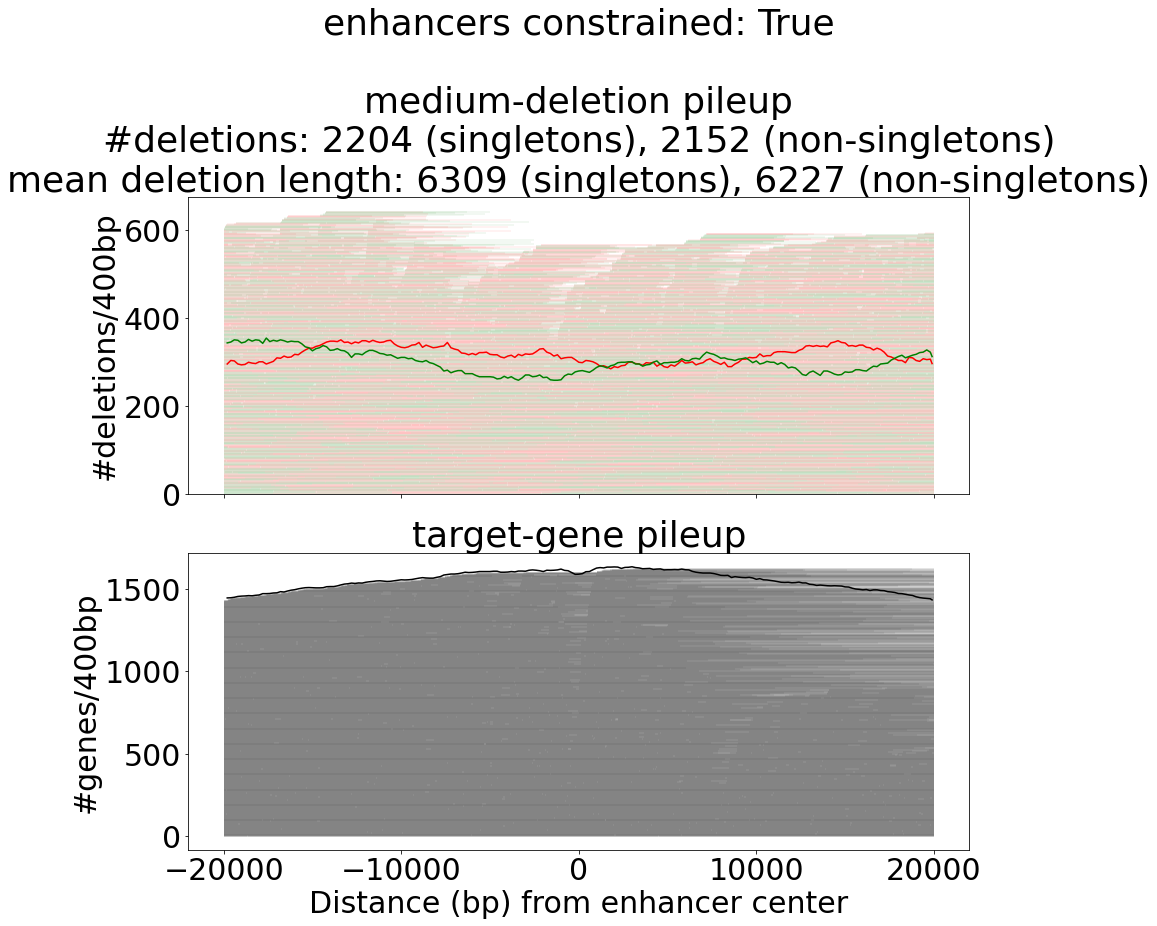

Wrote windows with deletion overlaps to: /scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/enhancer-straddling-windows/constraint-labeled/enhancer-straddling-windows-intersect-medium-observed-deletions.bed



Wrote deletions: /scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/enhancer-straddling-windows/constraint-labeled/medium-observed-singleton-deletions.bed
Wrote deletions: /scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/enhancer-straddling-windows/constraint-labeled/medium-observed-non-singleton-deletions.bed


Wrote coverage: /scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/enhancer-straddling-windows/constraint-labeled/medium-observed-singleton-deletions-coverage.bed

Wrote coverage: /scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/enhancer-straddling-windows/constraint-labeled/medium-observed-non-singleton-deletions-coverage.bed

True    352
Name: enhancer and gene on same chromosome, dtype: int64
Wrote coverage: /scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/enhancer-straddling-windows/constraint-labeled/genes-targeted-by-enhancers-coverage.bed



Wrote genes: /scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/enhancer-straddling-windows/constraint-labeled/genes-targeted-by-enhancers.bed


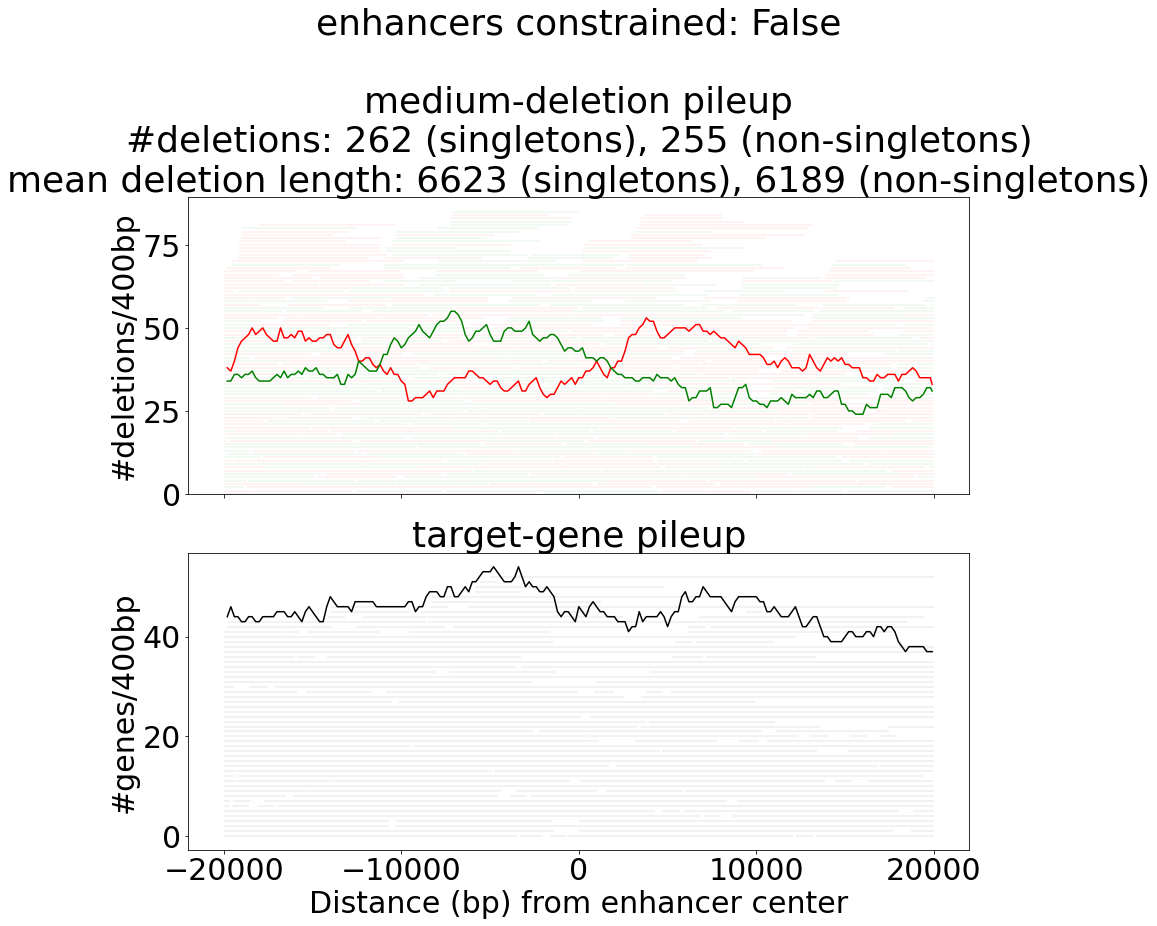

Wrote windows with deletion overlaps to: /scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/enhancer-straddling-windows/constraint-labeled/enhancer-straddling-windows-intersect-long-observed-deletions.bed



Wrote deletions: /scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/enhancer-straddling-windows/constraint-labeled/long-observed-singleton-deletions.bed


Wrote coverage: /scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/enhancer-straddling-windows/constraint-labeled/long-observed-singleton-deletions-coverage.bed



Wrote deletions: /scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/enhancer-straddling-windows/constraint-labeled/long-observed-non-singleton-deletions.bed


Wrote coverage: /scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/enhancer-straddling-windows/constraint-labeled/long-observed-non-singleton-deletions-coverage.bed

True    3677
Name: enhancer and gene on same chromosome, dtype: int64


Wrote genes: /scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/enhancer-straddling-windows/constraint-labeled/genes-targeted-by-enhancers.bed


Wrote coverage: /scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/enhancer-straddling-windows/constraint-labeled/genes-targeted-by-enhancers-coverage.bed



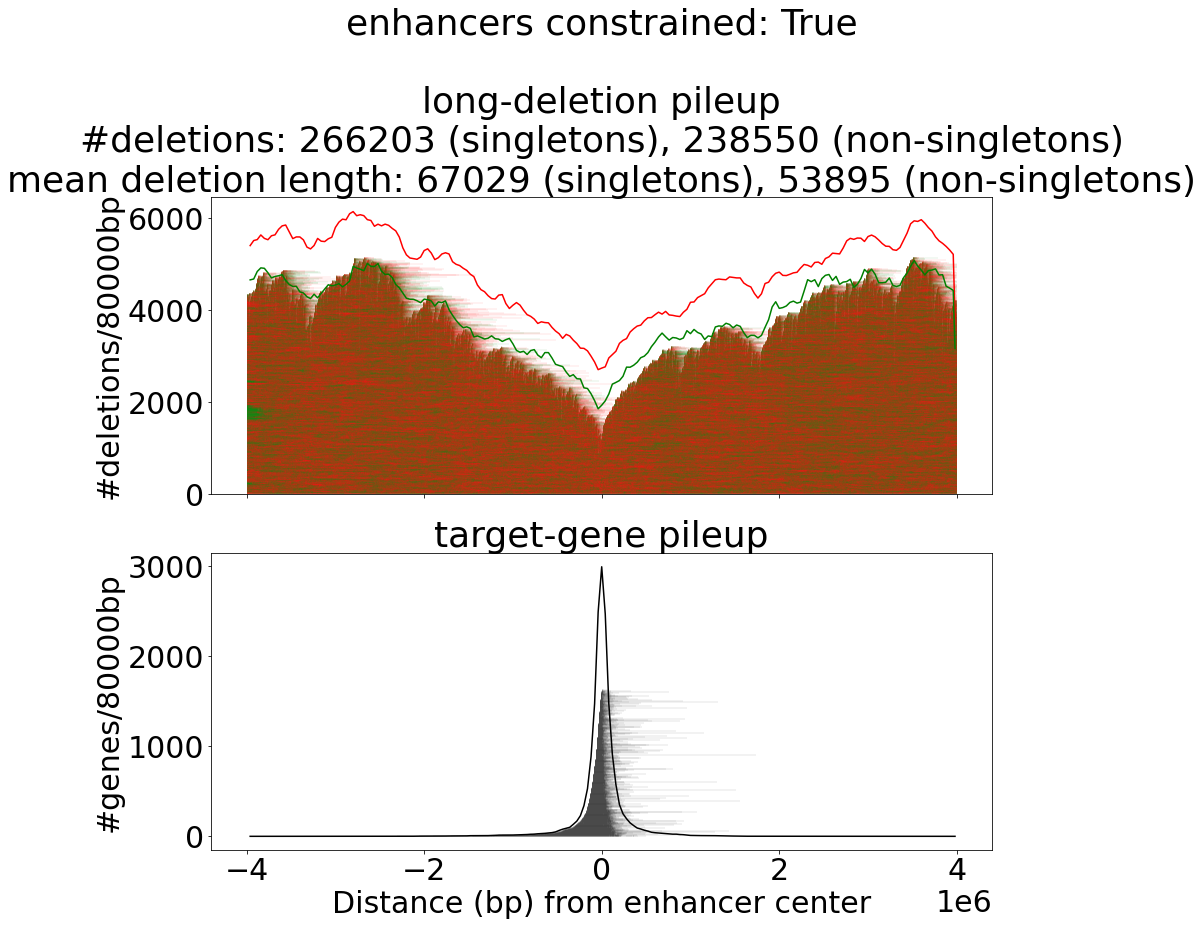

Wrote windows with deletion overlaps to: /scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/enhancer-straddling-windows/constraint-labeled/enhancer-straddling-windows-intersect-long-observed-deletions.bed



Wrote deletions: /scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/enhancer-straddling-windows/constraint-labeled/long-observed-singleton-deletions.bed


Wrote coverage: /scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/enhancer-straddling-windows/constraint-labeled/long-observed-singleton-deletions-coverage.bed



Wrote deletions: /scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/enhancer-straddling-windows/constraint-labeled/long-observed-non-singleton-deletions.bed


Wrote coverage: /scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/enhancer-straddling-windows/constraint-labeled/long-observed-non-singleton-deletions-coverage.bed

True    352
Name: enhancer and gene on same chromosome, dtype: int64


Wrote genes: /scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/enhancer-straddling-windows/constraint-labeled/genes-targeted-by-enhancers.bed


Wrote coverage: /scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/enhancer-straddling-windows/constraint-labeled/genes-targeted-by-enhancers-coverage.bed



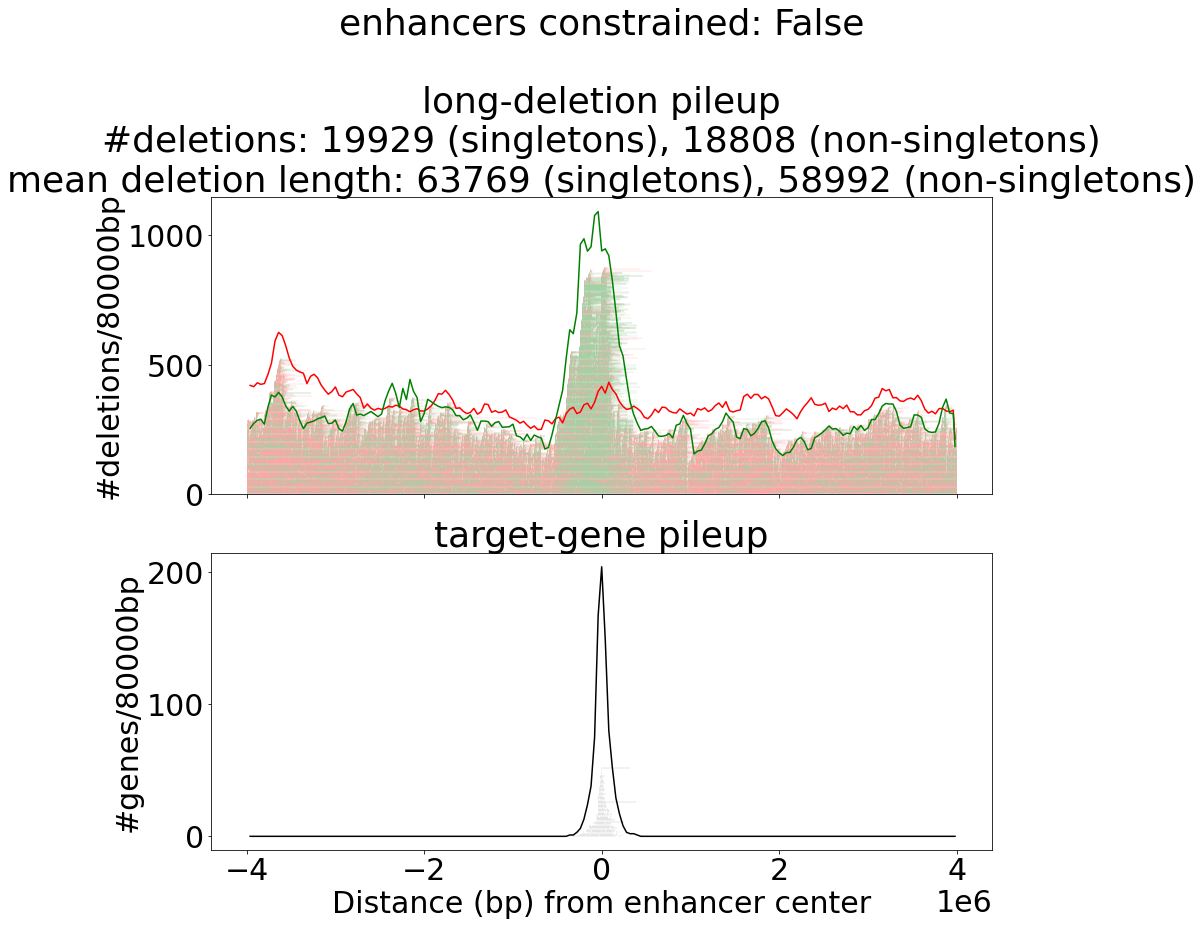

In [13]:
for deletion_type, window_size, ymax in zip(
  ['short', 'medium', 'long'],
  [20000, 40000, 8000000],
  # [300, 700, 6000],
  [None]*3
): 
  for constrained in [True, False]: 
    plot_pileup_and_coverage(
      deletion_type, 
      window_size,
      constrained,
      ymax, 
      plot_coverage=True
    )